# CHALLENGE 3: Robotic Autonomy
For this challenge, we will consider a robot that needs to move from its current position to a goal position across challenging terrain,
avoiding obstacles along the way and conserving as much energy as possible.

Download the elevation map of the terrain (Elevation.csv) from the challenge website to get started. The map is on a grid made out of
cells with integer coordinates, where the robot can move from each cell $(x, y)$ to any of its 8 neighbours, $(x + a, y + b)$ where $−1 ≤ a ≤
1, −1 ≤ b ≤ 1, a + b ≥ 1$.

The robot starts from (0, 0) . What is the robot’s lowest cost to reach the goal position (90, 50)? Round the lowest cost to
1 decimal place.

Within the elevation map:
- The first row gives the x-coordinate scale.
- The first column gives the y-coordinate scale.
- Other values give elevation, in meters.

The energy cost of taking a step is the sum of horizontal cost and climbing cost, where:
- Horizontal cost: $\sqrt{a^2 + b^2}$
- Climbing cost: 10 times the increase in elevation in meters (no climbing cost if going to the same or lower elevation)

Examples:
- Taking a step from (0, 0) which has an elevation of 7.9 to (1, 1) which has an elevation of 8.5 will cost 2+6, or roughly 7.41 units.
- Taking a step from (0, 0) which has an elevation of 7.9 to (0, -1) which has an elevation of 7.5 will cost 1 unit.

In [1]:
import pandas as pd
import numpy as np
# Read CSV and rop unnecessary columns
csv_file_path = 'Elevation.csv'
df = pd.read_csv(csv_file_path)
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 242'])

In [2]:
# The column start from 130 and row start from -80 
# So we can just map (0,0) to (130, 80)
# And we can just map (90,50) to (80, 170)
assert df.iloc[130][80] == 7.9
assert df.iloc[80][170] == 4.1

In [3]:
def get_neighbors(cell):
    x = cell[0]
    y = cell[1]
    return [[x+1, y],[x, y+1], [x-1, y],[x, y-1], [x+1, y+1],[x-1, y+1], [x-1, y-1],[x+1, y-1]]

In [4]:
def calculate_cost(cur, adj):
    cur_height = df.iloc[cur[0], cur[1]]
    adj_height = df.iloc[adj[0], adj[1]]
    cost = dist(cur, adj)
    if cur_height < adj_height:
        cost += (adj_height-cur_height)*10
    return cost

In [5]:
import heapq as hq
from math import dist
goal = [80, 170]
start = [130, 80]
priority_queue = [(0, start)]
hq.heapify(priority_queue)
visited = []

In [6]:
cost_mat = pd.DataFrame(np.full(df.shape, np.inf))
cost_mat.iloc[start[0], start[1]] = 0

visualization_df = pd.DataFrame(np.full(df.shape, " "))
visualization_df.iloc[start[0], start[1]] = "S"

dummy = df.copy()

In [7]:
frames = [dummy.copy()]

while priority_queue:
    cost, cur = hq.heappop(priority_queue)
    
    if cur == goal:
        break
    
    if cur in visited:
        continue

    visited.append(cur)
    visualization_df.iloc[cur[0], cur[1]] = "V"
    dummy.iloc[cur[0], cur[1]] = cost/10
    frames.append(dummy.copy())

    for neighbor in get_neighbors(cur):
        neighbor_cost = calculate_cost(cur, neighbor)
        total_cost = cost_mat.iloc[cur[0], cur[1]] + neighbor_cost

        if total_cost < cost_mat.iloc[neighbor[0], neighbor[1]]:
            cost_mat.iloc[neighbor[0], neighbor[1]] = total_cost
            priority = total_cost + dist(neighbor, goal)
            hq.heappush(priority_queue, (priority, neighbor))

print('Done with search')

# Mark the path in the visualization DataFrame
cur = goal
while cur != start:
    visualization_df.iloc[cur[0], cur[1]] = "P"
    dummy.iloc[cur[0], cur[1]] = 0
    frames.append(dummy.copy())
    best_neighbor = None
    min_cost = float('inf')
    for neighbor in get_neighbors(cur):
        temp = cost_mat.iloc[neighbor[0], neighbor[1]]
        if temp < min_cost:
            min_cost = temp
            best_neighbor = neighbor
    cur = best_neighbor

Done with search


In [8]:
round(cost_mat.iloc[goal[0], goal[1]], 1)

181.7

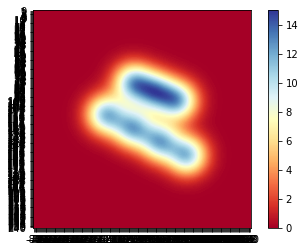

In [9]:
import matplotlib.pyplot as plt
plt.imshow(df, cmap ="RdYlBu")
plt.colorbar()
plt.xticks(range(len(df)), df.columns)
plt.yticks(range(len(df)), df.index)
plt.show()

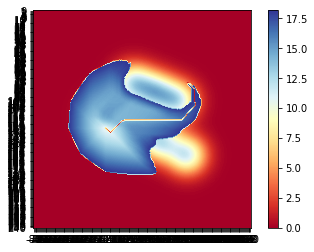

In [10]:
plt.imshow(dummy, cmap ="RdYlBu")
plt.colorbar()
plt.xticks(range(len(df)), df.columns)
plt.yticks(range(len(df)), df.index)
plt.show()

11200it [02:17, 81.72it/s]                           


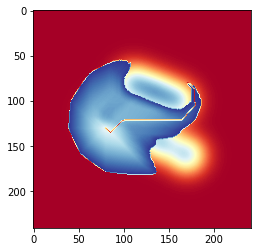

In [11]:
from matplotlib import animation
from tqdm import tqdm
pbar = tqdm(total=len(frames)+50*10)

fig = plt.figure()
def init():
    plt.imshow(df, cmap ="RdYlBu")

def animate(i):
    if i < len(frames):
        pbar.update(50)
        data = frames[i]
        plt.imshow(data, cmap ="RdYlBu")
    else:
        pbar.update(50)
        data = frames[-1]
        plt.imshow(data, cmap ="RdYlBu")


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=range(0, len(frames)+50*10, 50), repeat = False, interval=1)

savefile = r"path_finding.gif"
pillowwriter = animation.PillowWriter(fps=10)
anim.save(savefile, writer=pillowwriter)
    
pbar.close()
plt.show()